In [165]:
import warnings
warnings.filterwarnings('ignore')

In [166]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [167]:
import numpy as np
import pandas as pd
import sys
import time
import datetime
import requests as r
import json
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone

In [ ]:
pd.set_option('display.max_columns', None)

In [4]:
!pip freeze > requirements.txt
RANDOM_SEED = 42

In [ ]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

In [5]:
#запишем функцию для вычисления итоговой метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# переводим в удобный для нас вид
#df = pd.DataFrame(cars_list)
# проверяем на дубликаты, можно по двум признакам car_url или sell_id
#df['sell_id'].duplicated().sum()
# сохраняем в csv
#df.to_csv('cars_df.csv', index=False)

In [8]:
#Setup
VERSION    = 16
VAL_SIZE   = 0.20
#DIR_TRAIN  = ''
#DIR_TEST   = ''
#DIR_TEST   = '../input/sf-dst-car-price-prediction/'
#DIR_TRAIN  = '../input/data-car-ads/'
#Jupyter
DIR_TEST   = 'input/sf-dst-car-price-prediction/'
DIR_TRAIN  = 'input/data-car-ads/'

In [9]:
#Data
train = pd.read_csv(DIR_TRAIN+'cars_df.csv')
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [12]:
# первичный осмотр
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(5))
print('Размерность тестового датасета: ', test.shape)
display(test.head(5))

Размерность тренировочного датасета:  (33531, 25)


,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,priceCurrency,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price
0,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/e_klas...,чёрный,Автомобиль в который вложена Душа не требует о...,3.2 LTR,220 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,240 000 км,1992,Mercedes-Benz E-Класс I (W124) 320,3.2 AT,4,RUB,1994,SEDAN AUTOMATIC 3.2,автоматическая,3 или более,Оригинал,задний,Левый,Не требует ремонта,Растаможен,3 000 000 ₽
1,хэтчбек 5 дв.,CHEVROLET,https://auto.ru/cars/used/sale/chevrolet/aveo/...,белый,Я СОБСТВЕННИК!!! НЕ ПЕРЕКУП\nМашина в основном...,1.6 LTR,115 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,53 800 км,2011,Chevrolet Aveo II,1.6 AT,5,RUB,2013,HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,638 000 ₽
2,внедорожник 5 дв.,LAMBORGHINI,https://auto.ru/cars/used/sale/lamborghini/uru...,жёлтый,Год выпуска: 2019. Пробег: 40 100 км. Кузов: в...,4.0 LTR,650 N12,бензин,https://autoru.naydex.net/dVb17C804/f1af98yqCU...,40 100 км,2017,Lamborghini Urus I,4.0 AT,5,RUB,2019,ALLROAD_5_DOORS AUTOMATIC 4.0,автоматическая,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен,22 000 000 ₽
3,седан,BMW,https://auto.ru/cars/used/sale/bmw/m3/11034070...,синий,"M3 2016 Рестайлинг,Individual в цвете tanzanit...",3.0 LTR,431 N12,бензин,https://autoru.naydex.net/dVb17C804/f1af98yqCU...,50 000 км,2014,BMW M3 V (F80),3.0 AMT,4,RUB,2016,SEDAN ROBOT 3.0,роботизированная,2 владельца,Оригинал,задний,Левый,Не требует ремонта,Растаможен,4 740 000 ₽
4,купе,MCLAREN,https://auto.ru/cars/used/sale/mclaren/720s/11...,чёрный,"В продаже McLaren 720S Perfomance, в идеальном...",4.0 LTR,720 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,4 500 км,2017,McLaren 720S,4.0 AMT,2,RUB,2018,COUPE ROBOT 4.0,роботизированная,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен,22 500 000 ₽


Размерность тестового датасета:  (34686, 32)


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [13]:
#Data Preprocessing

In [14]:
# удаляем дубликаты
train = train.drop_duplicates(subset=['car_url'])

In [15]:
# проверим датасеты на дубликаты по уникальному идентификатору объявления
train['car_url'].duplicated().sum()
test['sell_id'].duplicated().sum()

0

In [16]:
# удалим из тестового датафрейма следующие признаки 
test.drop(['complectation_dict', 'equipment_dict', 'model_info',
           'super_gen', 'vendor', 'Владение'], axis=1, inplace=True)

In [18]:
test['price'] = 0
df_train = train
df_test = test

# удалим строки, где отсутствует цена
df_train = df_train.dropna(axis=0, subset=['price'])

# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [19]:
# еще раз проверим на дубликаты
# Для этого приведем их к одному виду int, т.к. формат в трейне и тесте отличается.
data['car_url'].value_counts()
data = data.drop_duplicates(subset=['car_url'])

## EDA

### Рассмотрим каждый признак

In [21]:
#Будем добавлять признаки в определенный список:
#числовые:
num_cols = []

# бинарные, количество уникальных значений которых равно двум
bin_cols = []

# категориальные
cat_cols = []

In [22]:
#bodyType

In [23]:
data.bodyType.value_counts()

внедорожник 5 дв.          24589
седан                      23849
хэтчбек 5 дв.               4215
лифтбек                     4159
универсал 5 дв.             2319
минивэн                     1710
купе                        1499
компактвэн                   900
хэтчбек 3 дв.                829
пикап двойная кабина         482
купе-хардтоп                 285
внедорожник 3 дв.            203
фургон                       195
родстер                      166
кабриолет                    126
седан-хардтоп                 29
микровэн                      16
пикап одинарная кабина         9
пикап полуторная кабина        7
седан 2 дв.                    6
лимузин                        6
внедорожник открытый           4
тарга                          2
фастбек                        2
универсал 3 дв.                1
хэтчбек 4 дв.                  1
Name: bodyType, dtype: int64

In [24]:
data['bodyType'] = data['bodyType'].astype(str).apply(lambda x: None if x.strip()=='' else x)
data['bodyType'] = data.bodyType.apply(lambda x: x.split(' ')[0].lower())

In [25]:
data.bodyType.value_counts()

внедорожник      24796
седан            23855
хэтчбек           5045
лифтбек           4159
универсал         2320
минивэн           1710
купе              1499
компактвэн         900
пикап              498
купе-хардтоп       285
фургон             195
родстер            166
кабриолет          126
седан-хардтоп       29
микровэн            16
лимузин              6
фастбек              2
тарга                2
Name: bodyType, dtype: int64

<AxesSubplot:>

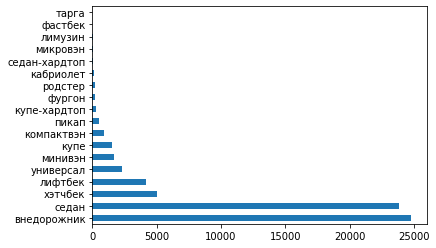

In [26]:
#посмотрим на распределение
data.bodyType.value_counts().plot.barh() 

In [27]:
cat_cols.append('bodyType')

In [168]:
#Данные распределились более равномерно. Признак отнесем к категориальным

In [28]:
#brand

In [29]:
data.brand.value_counts()

BMW            8137
VOLKSWAGEN     8106
NISSAN         7793
MERCEDES       7781
TOYOTA         7445
               ... 
ZOTYE             1
IRAN_KHODRO       1
DATSUN            1
DW_HOWER          1
SATURN            1
Name: brand, Length: 70, dtype: int64

In [169]:
#Признак категориальный. Дополнительная обработка не требуется.

In [30]:
cat_cols.append('brand')

In [31]:
#color

In [32]:
data.color.value_counts()

чёрный         20414
белый          12474
серый           8122
серебристый     6977
синий           6171
коричневый      3012
красный         2928
зелёный         1605
бежевый         1205
голубой          830
золотистый       448
пурпурный        443
фиолетовый       362
жёлтый           341
оранжевый        259
розовый           18
Name: color, dtype: int64

<AxesSubplot:>

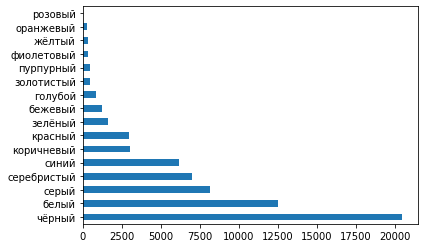

In [33]:
data.color.value_counts().plot.barh() 

In [34]:
#Дополнительной обработки признак не требует,пропусков нет,определяем его в "категориальные"
cat_cols.append('color')

In [35]:
#Description

In [36]:
# description - описание, комментарий продавца
# сгенерируем числовой признак - количество символов в описании
data['description_len'] = data.description.apply(lambda x: len(str(x)))
# сам description удалим

In [37]:
data = data.drop('description',axis=1)

In [38]:
#Определим его как числовой признак
num_cols.append('description_len')

In [39]:
#fuelType

In [40]:
data.fuelType.value_counts() #категориальный признак

бензин     53453
дизель     11599
гибрид       407
электро      137
газ           13
Name: fuelType, dtype: int64

<AxesSubplot:xlabel='fuelType', ylabel='count'>

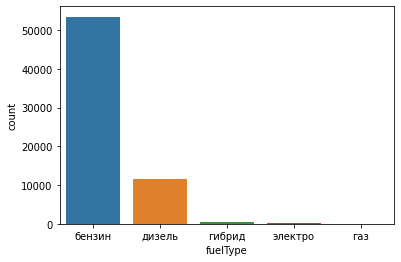

In [41]:
sns.countplot(x = 'fuelType', data = data)

In [42]:
#пропусков нет,дополнительной обработки не требуется,добавим признак в категориальные
cat_cols.append('fuelType')

In [43]:
#image

In [44]:
# image - фото автомобиля
# проверим фото на уникальность
count_photos = data.image.value_counts()
display(count_photos.head(5))

https://avatars.mds.yandex.net/get-verba/216201/2a000001609d0005e0912c12a896bbda4ab1/wizardv3mr     20
https://avatars.mds.yandex.net/get-verba/216201/2a000001609bda17487cc63d8b957ab4aab2/wizardv3mr     13
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609cf6746b94cf8334836265daaf/wizardv3mr    13
https://avatars.mds.yandex.net/get-verba/216201/2a0000016098487a9e1ff58d5ae35f3de345/wizardv3mr     13
https://avatars.mds.yandex.net/get-verba/216201/2a0000016099a4e6be992d7b50134fd908fd/wizardv3mr     12
Name: image, dtype: int64

In [45]:
#получим уникальные фотографии
display(count_photos.sort_values().head(5))

https://avatars.mds.yandex.net/get-autoru-vos/2172682/e96166eae075071625f65f2215b05e9a/320x240                                                                                                                                   1
https://autoru.naydex.net/G87gDZg56/28c7a8vqVE/xGtzQkxaH-LvfLMYcqnNjeKZWSgfkOxAh1jWB0acClC2yBpE7d1cW7XQArDG8wM0t90QetKxJqk9psR3BOLhAIJ6eAgFXguzr3j0U2n0zc_5gQtpSMekFtsJknd-uD8_iPI8YtjhP0yv10KshLFkX6KPZQiHwCXaXtjiRHK-lQ#DSD    1
https://avatars.mds.yandex.net/get-autoru-vos/4373680/2e3b78f67d926641ec5544d599b046e1/320x240                                                                                                                                   1
https://avatars.mds.yandex.net/get-autoru-vos/2079837/6ed2ed7897a89e3c0f1722f14e980002/320x240                                                                                                                                   1
https://autoru.naydex.net/mcQh17801/f1b5751dCi/ZpAxhySp-6XA9ZRjLXnaIoWog-BkhRn4qCmMkbY1cVFQT

In [46]:
# можно сделать из этого бинарный признак по типу уникальности фото
data['real_photo'] = data.image.apply(lambda x: x.find('get-verba') == -1)

real = data[data['real_photo'] == False].image.value_counts()
display(real.sort_values().head(5))
# сам признак image удалим

https://avatars.mds.yandex.net/get-verba/1030388/2a000001609d5c8cb4d2ea47d66bdedd2d76/wizardv3mr    1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609d5b556b13655b7d779bbd50d8/wizardv3mr     1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609d1365201eac35efd34146c7a4/wizardv3mr     1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609cf703e4dc5fbc0d8c9699a85e/wizardv3mr     1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609d518b1e62d58e4cf3c5dabe5c/wizardv3mr     1
Name: image, dtype: int64

In [47]:
data = data.drop('image',axis=1)

In [48]:
data['real_photo'].value_counts()

True     65046
False      563
Name: real_photo, dtype: int64

<AxesSubplot:xlabel='real_photo', ylabel='count'>

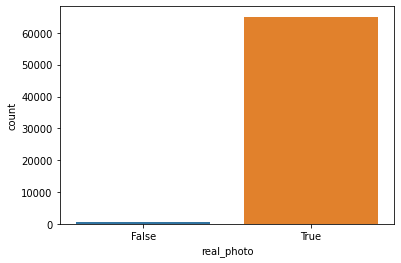

In [49]:
sns.countplot(x = 'real_photo', data = data)

In [50]:
#После проверки неуникальных фото, можнл сделать вывод, что использовались шаблонные фото.
#Реальных фото оказалось большинство
bin_cols.append('real_photo')

In [51]:
#engineDisplacement

In [52]:
data.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', '6.8 LTR', '0.8 LTR', '6.4 LTR', '6.5 LTR', '0.9 LTR',
       '0.6 LTR'], dtype=object)

In [53]:
data.engineDisplacement.value_counts()

2.0 LTR    14515
1.6 LTR     9973
3.0 LTR     7514
1.8 LTR     5805
2.5 LTR     4606
           ...  
6.4 LTR        2
0.9 LTR        1
3.9 LTR        1
6.5 LTR        1
0.6 LTR        1
Name: engineDisplacement, Length: 61, dtype: int64

In [54]:
#оставим только численное значение 
data.engineDisplacement = data.engineDisplacement.apply(lambda x: x[:3])
data.engineDisplacement = data.engineDisplacement.replace(' LT', '0.0') #electro car.
data.engineDisplacement = data.engineDisplacement.apply(lambda x: float(x))

In [55]:
#разобьем по категориям
data["engineDisplacement"] = data["engineDisplacement"].astype('float').apply(lambda x: 4 if x >= 3.5 else 
   3 if x >= 2.5 else(2 if x >= 1.5 else (1 if x >= 0.1 else 0)))
data.engineDisplacement.value_counts()

2    36622
3    14384
4     9376
1     5090
0      137
Name: engineDisplacement, dtype: int64

<AxesSubplot:xlabel='engineDisplacement', ylabel='count'>

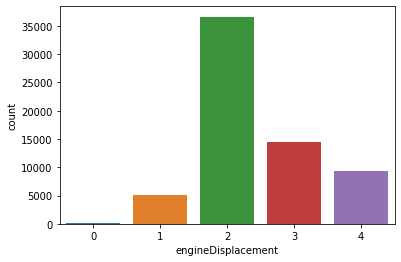

In [56]:
sns.countplot(x = 'engineDisplacement', data = data)

In [57]:
cat_cols.append('engineDisplacement')

In [58]:
#enginePower

In [59]:
data.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [60]:
#преобразуем данные
data['enginePower'] = data['enginePower'].apply(lambda x: x[:3])
data['enginePower'] = data['enginePower'].replace('7 N','7')
data['enginePower'] = data['enginePower'].apply(lambda x: int(x))

<bound method Axes.barh of <AxesSubplot:>>

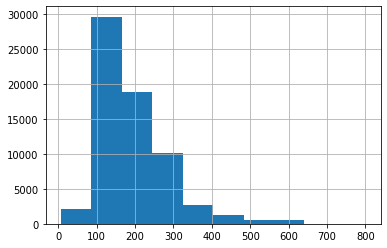

In [61]:
data.enginePower.hist().barh

In [62]:
#добавим в числовой признак
num_cols.append('enginePower')

In [63]:
#mileage

In [64]:
data['mileage'].value_counts()

200000    448
300000    392
150000    389
250000    364
180000    353
         ... 
107727      1
42192       1
244964      1
280898      1
6406        1
Name: mileage, Length: 25629, dtype: int64

In [65]:
#Почистим данные
data['mileage'] = data['mileage'].apply(lambda x: str(x).replace('\xa0км', ''))

In [66]:
data['mileage'] = data.mileage.apply(
    lambda x: int("".join(filter(str.isdigit, x))))

In [67]:
#Создадим категориальный признак 'mileage_cat'  
data["mileage_cat"] = data["mileage"].apply(lambda x: 4 if x>=40000 else(3 if x>=30000 else(2 if x>=20000 else (1 if x>=10000 else 0))))

In [68]:
data.mileage_cat.value_counts()

4    58896
3     1845
2     1699
1     1595
0     1574
Name: mileage_cat, dtype: int64

In [69]:
num_cols.append('mileage')
cat_cols.append('mileage_cat')

In [70]:
#productionDate и modelDate

In [71]:
data.productionDate.value_counts()

2012    5382
2013    4933
2011    4772
2014    4467
2008    4410
        ... 
1962       1
1961       1
1957       1
1948       1
1949       1
Name: productionDate, Length: 74, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


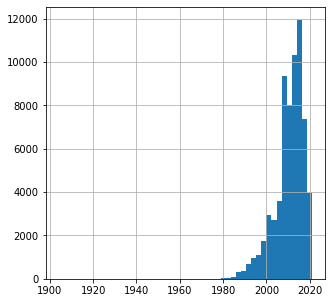

In [72]:
print(data['productionDate'].hist(figsize=(5,5), bins=50))

In [73]:
data.modelDate.value_counts()

2013    4646
2012    4616
2011    4340
2014    4191
2010    4056
        ... 
1904       1
1965       1
1946       1
1952       1
1950       1
Name: modelDate, Length: 73, dtype: int64

In [74]:
#создадим новые признаки на основе существующих: количество лет производства и возраст модели
data['prod_age'] = 2021 - data.productionDate
data['model_age'] = 2021 - data.modelDate

In [75]:
#определим эти признаки в числовые данные
num_cols.append('productionDate')
num_cols.append('modelDate')
num_cols.append('prod_age')
num_cols.append('model_age')

In [76]:
#model_name

In [77]:
data.model_name.unique()

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', ..., 'VAMOS', 'CAPA', 'MDX'],
      dtype=object)

In [78]:
cat_cols.append('model_name')

In [79]:
#numberOfDoors

In [80]:
data.numberOfDoors.value_counts() #категориальный признак,не требующий доп.обработки

5    36866
4    25512
2     2129
3     1101
0        1
Name: numberOfDoors, dtype: int64

<AxesSubplot:xlabel='numberOfDoors', ylabel='count'>

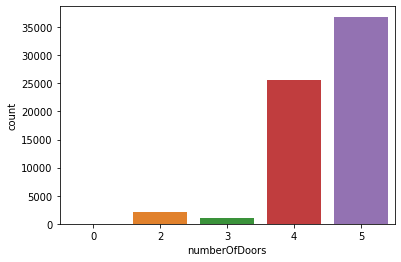

In [81]:
sns.countplot(x = 'numberOfDoors', data = data)

In [82]:
cat_cols.append('numberOfDoors')

In [83]:
#sell_id

In [84]:
test.sell_id.isna().sum()

0

In [85]:
#sell_id

In [ ]:
#идентификатор объявления,который у нас есть в test-вборке. Данный признак уникален, пропусков не осталось. Признак является идентификатором объявления. Смысловой нагрузки не несет, для обучение не отбираем

In [86]:
#vehicleTransmission

In [87]:
data.vehicleTransmission.value_counts()

автоматическая      37639
механическая        12662
роботизированная     7798
вариатор             7510
Name: vehicleTransmission, dtype: int64

<AxesSubplot:xlabel='vehicleTransmission', ylabel='count'>

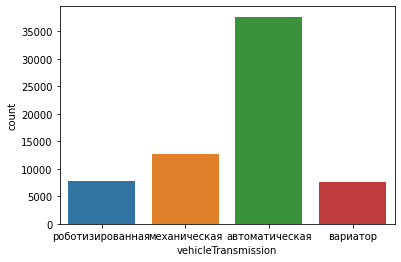

In [88]:
sns.countplot(x = 'vehicleTransmission', data = data)

In [89]:
#определяем в категориальный признак
cat_cols.append('vehicleTransmission')

In [90]:
#Владельцы

In [91]:
data['Владельцы'].value_counts()

3 или более    27688
1 владелец     11879
2 владельца    10713
1 владелец      8517
2 владельца     6812
Name: Владельцы, dtype: int64

In [92]:
#почистим данные, оставим только количество владельцев
data['Владельцы'] = data['Владельцы'].apply(lambda x: int(x[0])).astype('int32')

In [93]:
data.Владельцы.value_counts()

3    27688
1    20396
2    17525
Name: Владельцы, dtype: int64

<AxesSubplot:xlabel='Владельцы', ylabel='count'>

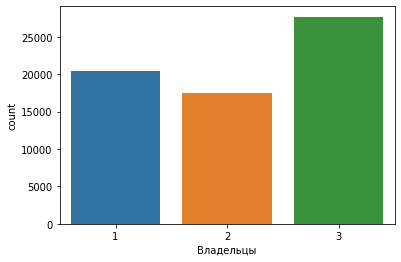

In [94]:
sns.countplot(x = 'Владельцы', data = data)

In [95]:
cat_cols.append('Владельцы')

In [96]:
#ПТС

In [97]:
data.ПТС.value_counts()

Оригинал    57486
Дубликат     8122
Name: ПТС, dtype: int64

In [98]:
data.ПТС.isna().sum()

1

In [99]:
data.ПТС = data.ПТС.fillna('Оригинал')# заполним пропуск наиболее частым значением

In [100]:
# Преобразуем значения в колонке ПТС
data['ПТС'] = data['ПТС'].apply(lambda x: 1 if x == 'Оригинал' else 0).astype('int8')

<AxesSubplot:xlabel='ПТС', ylabel='count'>

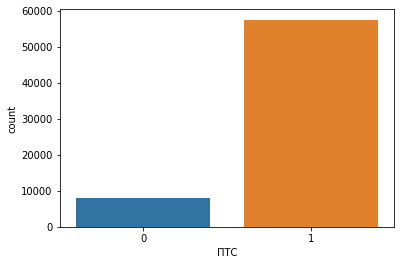

In [101]:
sns.countplot(x = 'ПТС', data = data)

In [102]:
#определяем в бинарные признаки
bin_cols.append('ПТС')

In [103]:
#Привод

In [104]:
data.Привод.value_counts()

передний    29352
полный      29242
задний       7015
Name: Привод, dtype: int64

<AxesSubplot:xlabel='Привод', ylabel='count'>

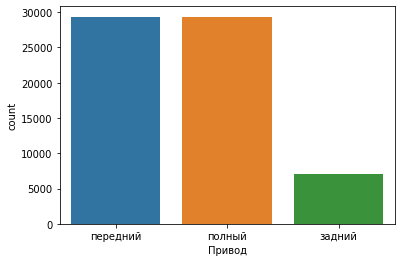

In [105]:
#посмотрим на распределение
sns.countplot(x = 'Привод', data = data)

In [170]:
#Признак категориальный. Дополнительная обработка не требуется

In [106]:
cat_cols.append('Привод')

In [107]:
#Руль

In [108]:
data.Руль.value_counts()

Левый     63355
Правый     2254
Name: Руль, dtype: int64

In [109]:
# Преобразуем значения в колонке Руль
data['Руль'] = data['Руль'].apply(lambda x: 1 if x == 'Левый' else 0).astype('int8')

<AxesSubplot:xlabel='Руль', ylabel='count'>

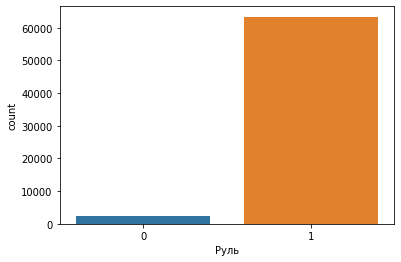

In [110]:
sns.countplot(x = 'Руль', data = data)

In [111]:
bin_cols.append('Руль')

In [112]:
#Состояние

In [113]:
data.Состояние.unique()

array(['Не требует ремонта', 'Битый / не на ходу'], dtype=object)

In [114]:
# Преобразуем значения в колонке Состояние
data['Состояние'] = data['Состояние'].apply(lambda x: 1 if x == 'Не требует ремонта' else 0).astype('int8')

In [115]:
data.Состояние.value_counts()

1    65607
0        2
Name: Состояние, dtype: int64

In [116]:
bin_cols.append('Состояние')

In [117]:
#Посмотрим на распределение целевой переменной:

In [118]:
# приведем целевую переменную к числовому типу
data['price'] = data['price'].apply(lambda x: str(x))

In [119]:
# приведем целевую переменную к числовому типу
data.price = data.price.apply(
    lambda x: ("".join(filter(str.isdigit, x)))).astype('int')

<AxesSubplot:title={'center':'Распределение price'}, xlabel='price'>

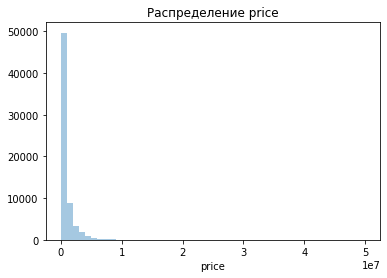

In [120]:
plt.figure()
plt.title(f"Распределение {'price'}")
sns.distplot(data.price, kde=False)

In [121]:
#Посмотрим на распределение зависимости цены от марки авто:

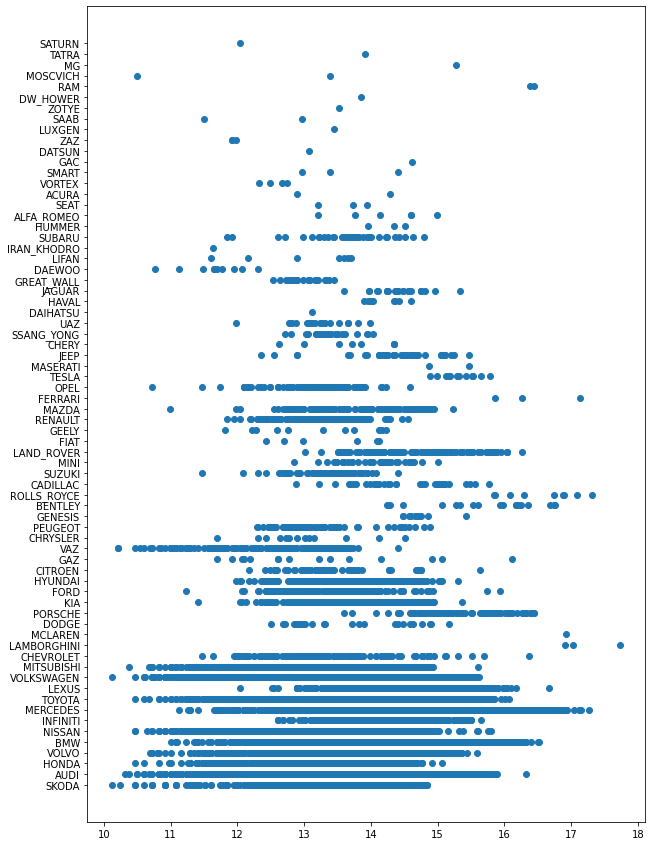

In [122]:
plt.figure(figsize=(10, 15))
plt.scatter(np.log(data.price), data.brand)

In [123]:
#Показывает что цены адекватны и зависят от марки авто

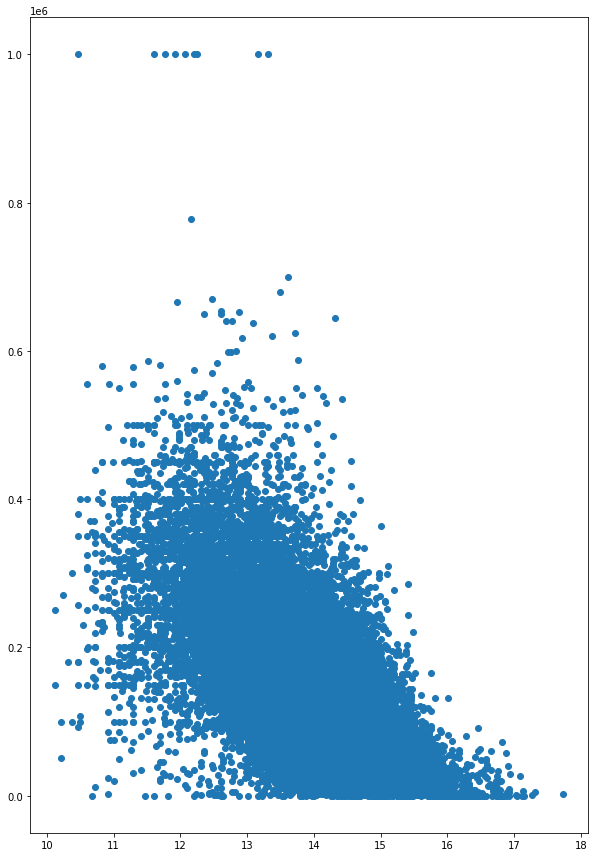

In [124]:
#Посмотрим на распределение зависимости цены от километража
plt.figure(figsize=(10, 15))
plt.scatter(np.log(data.price), data.mileage)

In [125]:
#Удалим признаки, которые на наш взгляд не несут никакой информативности,либо дублируют информацию:

In [126]:
data = data.drop(columns = ['car_url','name','sell_id','parsing_unixtime','vehicleConfiguration','priceCurrency','Таможня'], axis=1)

In [127]:
#Label Encoding

In [128]:
for colum in ['bodyType','color','model_name','brand','fuelType', 'vehicleTransmission','Привод','real_photo']:
    data[colum] = data[colum].astype('category').cat.codes

In [129]:
#Бинарные признаки

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:98: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:98: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

<AxesSubplot:>

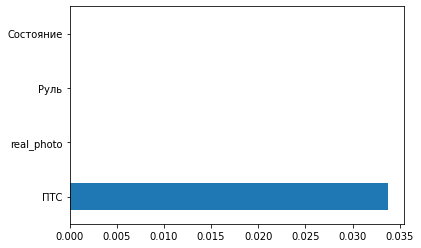

In [130]:
#Проверим значимость бинарных переменных:
df = data[data['sample'] == 0]
imp_cat = Series(mutual_info_classif(data[bin_cols], data['price'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [131]:
#по графику видим,что сильно больше всего влияют признаки ПТС и Руль, real_photo на цену

<AxesSubplot:>

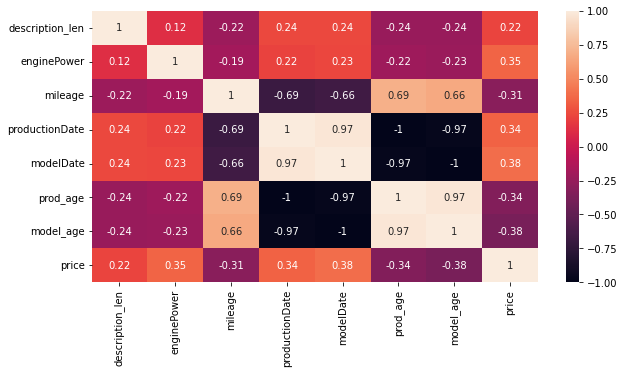

In [132]:
# построим матрицу корреляций для числовых признаков
plt.figure(figsize=(10,5))
sns.heatmap(data[num_cols+['price']].corr(), annot=True)

In [133]:
#Категориальные признаки

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:98: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:98: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

<AxesSubplot:>

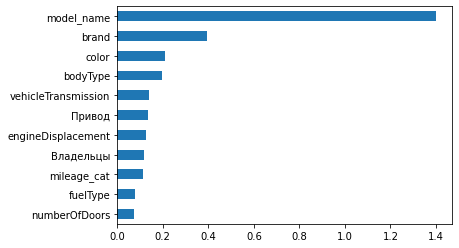

In [134]:
# Проверим значимость категориальных переменных:
temp_df = data[data['sample']==1]
imp_cat = Series(mutual_info_classif(data[cat_cols], data['price'],
                                     discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [135]:
#Числовые признаки

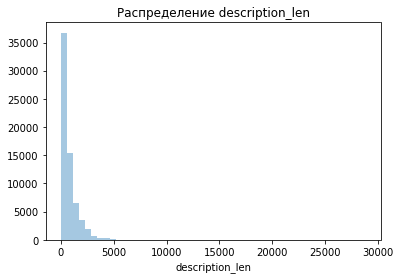

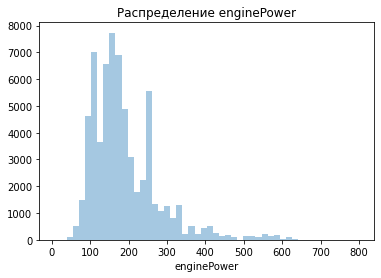

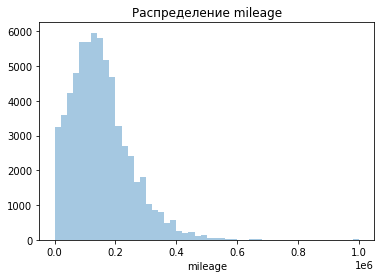

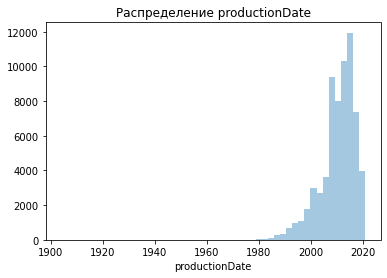

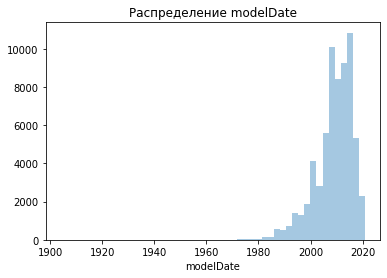

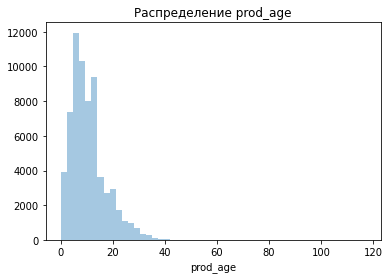

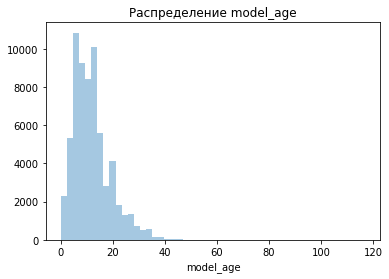

In [136]:
# анализ распределения числовых переменных с помощью визуализации
for col in num_cols:
    plt.figure()
    plt.title(f"Распределение {col}")
    sns.distplot(data[col], kde=False)

<AxesSubplot:>

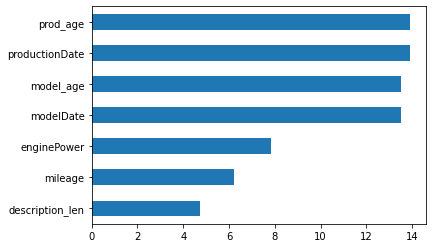

In [137]:
imp_num = Series(f_classif(data[num_cols][data['sample'] == 1], data[data['sample'] == 1]['price'])[0], 
                 index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [138]:
#Все признаки достаточно сильно влияют на цену

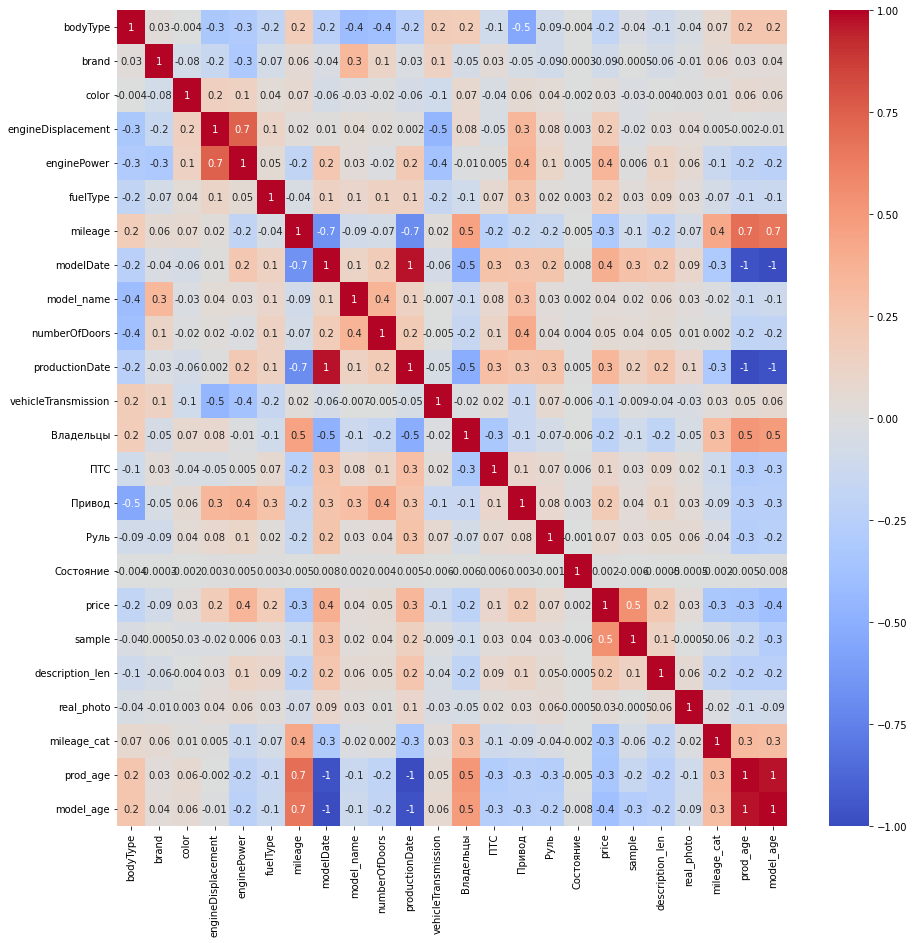

In [139]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax = sns.heatmap(data.corr(),fmt='.1g',
                 annot=True, cmap='coolwarm')

In [140]:
#Видна большая корреляция между признаками 'engineDisplacement' и 'enginePower',а так же искуственно созданными признаками. Удалять не будет,тк проведя эксперименты по машинному обучения,заметили, что результат метрики хуже.

In [141]:
#Train Split

In [142]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample','price'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [143]:
#Model 1: Создадим "наивную" модель

In [144]:
#Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). C ней будем сравнивать другие модели.

In [145]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [146]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())
VERSION = 1
#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 99.70%


In [147]:
#Простая модель линейной регрессии

In [148]:
from sklearn.linear_model import LinearRegression
linear_regr = LinearRegression().fit(X_train, np.log(y_train+1))
VERSION = 2
predict_test = np.exp(linear_regr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 26.40%


In [149]:
#CatBoost

In [150]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [151]:
# оцениваем точность
VERSION = 3
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 15.01%


In [152]:
#Log Target
#Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).

In [153]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')
predict_test = np.exp(model.predict(X_test))
#!!!!
predict_submission = np.exp(model.predict(test_data))
#VERSION = 4
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 12.55%


In [ ]:
#Random Forest

In [ ]:
rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1).fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf.predict(X_test))))*100:0.2f}%")
VERSION = 5
predict_submission = np.exp(rf.predict(test_data))

In [ ]:
#Зададим сетку гиперпараметров, которые будут перебираться:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
'''
Закомментируем из-за того, что выполняется очень долго
#Обучим наш лес:
#rf = RandomForestRegressor(random_state=42)
#rf_rand = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
#                              cv=3, verbose=2, random_state=42, n_jobs=-1)
#rf_rand.fit(X_train, np.log(y_train+1))
'''

In [ ]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf.predict(X_test))))*100:0.2f}%")
VERSION = 6
predict_submission = np.exp(rf_rand.predict(test_data))

In [ ]:
#xgboost

In [156]:
import xgboost as xgb
xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)
xb.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xb.predict(X_test))))*100:0.2f}%")
VERSION = 7
predict_test = np.exp(xb.predict(X_test))
predict_submission = np.exp(xb.predict(test_data))

Точность модели по метрике MAPE: 12.10%


In [ ]:
#GradientBoosting с подбором параметров

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
def regularise(X_train, y_train):
    max_depth = [5, 10,15]
    n_estimators = [100, 200,1000]
    hyperparameters = dict(max_depth=max_depth, n_estimators=n_estimators)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters)

    best_model = clf.fit(X_train, y_train)

    best_max_depth = best_model.best_estimator_.get_params()['max_depth']
    best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

    return best_max_depth, best_n_estimators

In [ ]:
'''
Закомментируем из-за того, что выполняется очень долго
#best_max_depth, best_n_estimators = regularise(X_train, y_train)
#best_max_depth, best_n_estimators
'''

In [ ]:
'''
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000)
gb.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(gb.predict(X_test))))*100:0.2f}%")
'''

In [ ]:
#Stacking

In [158]:
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 


y_train = y_train 
y_test = y_test

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    
    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)


    return X_meta_train, X_meta_test

def generate_meta_features(regr, X_train, X_test, y_train, cv):
    features = [compute_meta_feature(regr, X_train, X_test, y_train, cv) for regr in tqdm(regr)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test in features]).T
    return stacked_features_train, stacked_features_test

X_train = np.where(np.isnan(X_train), 0, X_train)
X_test = np.where(np.isnan(X_test), 0, X_test)
y_train = np.where(np.isnan(y_train), 0, y_train)

In [159]:
regr = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1, 
                             max_features=3, max_depth=19, bootstrap=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test = generate_meta_features([
                            regr,
                            GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300),
                            KNeighborsRegressor(n_neighbors=2, algorithm = 'ball_tree', weights = 'distance', p=1),
                            RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1, max_depth=5, n_estimators=200),
                            ExtraTreesRegressor(random_state=RANDOM_SEED), 
                            RandomForestRegressor(random_state=RANDOM_SEED, max_depth=15) \
], X_train, X_test, y_train, cv)

  0%|          | 0/6 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:428: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = (n_samples // n_splits) * np.ones(n_splits, dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:108: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:753: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
C:\ProgramData

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:108: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_mask = np.zeros(_num_samples(X), dtype=np.bool)
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:157: DeprecationWarning: `np.int` is a 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:157: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:108: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:157: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:108: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release

In [160]:
def compute_metric(regr, X_train, y_train, X_test, y_test): 
    regr.fit(X_train, y_train) 
    y_test_pred = regr.predict(X_test) 
    return np.round(mape(y_test, y_test_pred)*100, 2)
VERSION = 9
print(f"Точность модели по метрике MAPE: {compute_metric(regr, stacked_features_train, y_train, stacked_features_test, y_test)}%")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\base.py:157: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


Точность модели по метрике MAPE: 14.59%


Проведя ряд экспериментов можно сделать следующие выводы:

CatBoost+Log target и GradientBoosting отлично справляется и показывает хороший результат метрики, но лучший результат показал xgboost - 12.11.